In [1]:
import os
import shutil
import importlib
import copy
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torchaudio

import phaselocknet_model
import util

importlib.reload(phaselocknet_model)
importlib.reload(util)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [2]:
"""
Copy tensorflow model directories to new torch model directories for evaluation routine.
"""
# regex_dir_model_src = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch*"
# regex_dir_model_src = "../phaselocknet/models/sound_localization/simplified_IHC3000/arch*"
# regex_dir_model_src = "../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch*"
regex_dir_model_src = "../phaselocknet/models/sound_localization/exploration/multitask*"
args_replace = ("../phaselocknet/", "../phaselocknet_torch/") # String replacement to map src to dst directory
for dir_model_src in glob.glob(regex_dir_model_src):
    # Build torch model object
    model, _ = phaselocknet_model.get_model(dir_model_src)
    # Load model weights from tensorflow checkpoint
    util.load_tf_model_checkpoint(
        model=model.perceptual_model,
        filename=os.path.join(dir_model_src, "ckpt_BEST"),
    )
    # Prepare destination directory for torch model
    assert args_replace[0] in dir_model_src
    dir_model_dst = dir_model_src.replace(*args_replace)
    if not os.path.exists(dir_model_dst):
        os.makedirs(dir_model_dst)
    # Save weights and configuration to torch model directory
    util.save_model_checkpoint(
        model=model.perceptual_model,
        dir_model=dir_model_dst,
        step=None,
        fn_ckpt="ckpt_BEST.pt",
    )
    # Copy `config.json` and `arch.json` to destination directory
    for basename in ["config.json", "arch.json"]:
        shutil.copyfile(
            os.path.join(dir_model_src, basename),
            os.path.join(dir_model_dst, basename),
        )
    print(f"[COMPLETE] {dir_model_dst=}\n")


[get_model] dir_model='../phaselocknet/models/sound_localization/exploration/multitask_arch0_0000_grouped'
[get_model] |__ input_shape=[2, 60000, 2]
[get_model] |__ config_random_slice={'size': [50, 10000], 'buffer': [0, 1000]}


2024-11-14 11:00:09.114390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[load_tf_model_checkpoint] missing_keys (../phaselocknet/models/sound_localization/exploration/multitask_arch0_0000_grouped/ckpt_BEST)
|__ body.block0_pool.weight
|__ body.block1_pool.weight
|__ body.block2_pool.weight
|__ body.block3_pool.weight
|__ body.block4_pool.weight
|__ body.block5_pool.weight
|__ body.block6_pool.weight
[load_tf_model_checkpoint] ../phaselocknet/models/sound_localization/exploration/multitask_arch0_0000_grouped/ckpt_BEST
[save_model_checkpoint] ../phaselocknet_torch/models/sound_localization/exploration/multitask_arch0_0000_grouped/ckpt_BEST.pt
[COMPLETE] dir_model_dst='../phaselocknet_torch/models/sound_localization/exploration/multitask_arch0_0000_grouped'

[get_model] dir_model='../phaselocknet/models/sound_localization/exploration/multitask_arch0_0000_ungrouped'
[get_model] |__ input_shape=[2, 60000, 2]
[get_model] |__ config_random_slice={'size': [50, 10000], 'buffer': [0, 1000]}
[load_tf_model_checkpoint] missing_keys (../phaselocknet/models/sound_locali

In [40]:
"""
Minimal example of how to load a `phaselocknet` model directory into a torch model.
Please be aware torch and tensorflow model outputs will not exactly match due to
the stochastic spike sampling and small differences in numerical precision.
"""

# # Sound localization network with simplified auditory nerve model (operates on audio)
# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01"

# # Sound localization network with detailed auditory nerve model (operates on pre-computed auditory nerve representations)
# dir_model = "../phaselocknet/models/sound_localization/IHC3000_delayed_integration/arch01"

# Word + voice recognition network with simplified auditory nerve model (operates on audio)
dir_model = "../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000"

# # Word + voice recognition network with detailed auditory nerve model (operates on pre-computed auditory nerve representations)
# dir_model = "../phaselocknet/models/spkr_word_recognition/IHC3000/arch0_0000"

model, _ = phaselocknet_model.get_model(dir_model)

# Load model weights from tensorflow checkpoint
util.load_tf_model_checkpoint(
    model=model.perceptual_model,
    filename=os.path.join(dir_model, "ckpt_BEST"),
)
model.train(mode=False)
model.to(device)
assert not model.training


[get_model] dir_model='../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000'
[get_model] |__ input_shape=[2, 40000]
[get_model] |__ config_random_slice={'size': [50, 20000], 'buffer': [0, 0]}
[WARNING] layer_type='reshape' --> torch.nn.Identity
[load_tf_model_checkpoint] missing_keys (../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000/ckpt_BEST)
|__ body.block0_pool.weight
|__ body.block1_pool.weight
|__ body.block2_pool.weight
|__ body.block3_pool.weight
|__ body.block4_pool.weight
|__ body.block5_pool.weight
|__ body.block6_pool.weight
[load_tf_model_checkpoint] ../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000/ckpt_BEST


In [41]:
# regex_filenames = "../phaselocknet/stimuli/sound_localization/evaluation/speech_in_noise_in_reverb_v04/stim*hdf5"
regex_filenames = "../phaselocknet/stimuli/spkr_word_recognition/evaluation/pitch_altered_v00/stim*hdf5"

batch_size = 32
sr = 50000 if "sound_localization" in regex_filenames else 20000
num_steps_per_display = 10
dataset = util.HDF5Dataset(regex_filenames)


In [42]:
example = dataset[10]

print("Example structure:")
for k, v in example.items():
    print("|__", k, v.shape if v.ndim > 0 else v, v.dtype)

x = torch.tensor(example["signal"])[None, ...]
sr_src = example["sr"]
resampler = torchaudio.transforms.Resample(
    orig_freq=sr_src,
    new_freq=sr,
)
print(f"[evaluate] resampling audio from {sr_src} to {sr} Hz")
if x.ndim > 2:
    x = torch.stack(
        [resampler(x[..., channel]) for channel in range(x.shape[-1])],
        axis=-1,
    )
else:
    x = resampler(x)

x = util.pad_or_trim_to_len(x, n=model.input_shape[1], dim=1)
out = model(x.to(device))

print("Model output:")
for k, v in out.items():
    print("|__", k, v.shape if v.ndim > 0 else v, v.dtype)


Example structure:
|__ f0_shift_in_semitones nan float64
|__ foreground_condition 0 int64
|__ foreground_dbspl 60.0 float64
|__ foreground_index 10 int64
|__ index 10 int64
|__ inharmonic 0 int64
|__ label_speaker_int 277 int64
|__ label_word_int 19 int64
|__ signal (40000,) float32
|__ snr inf float64
|__ sr 20000 int64
|__ whispered 0 int64
[evaluate] resampling audio from 20000 to 20000 Hz
Model output:
|__ label_speaker_int torch.Size([1, 433]) torch.float32
|__ label_word_int torch.Size([1, 794]) torch.float32


In [43]:
np.argmax(out["label_word_int"][0].cpu().detach().numpy())


19

In [35]:
fn_eval_output = "tmp.csv"
overwrite = True
write_prob = True

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
)

if os.path.exists(fn_eval_output):
    if overwrite:
        print(f"[evaluate] Overwriting pre-existing {fn_eval_output=}")
        os.remove(fn_eval_output)
    else:
        print(f"[complete] {fn_eval_output=} already exists!")
        raise ValueError(f"[complete] {fn_eval_output=} already exists!")
if os.path.exists(fn_eval_output + "~"):
    print(f"[evaluate] Deleting pre-existing tempfile: {fn_eval_output}~")
    os.remove(fn_eval_output + "~")

if write_prob:
    df_prob = []
    fn_eval_prob = fn_eval_output.replace(".csv", "_prob.gz")
    if os.path.exists(fn_eval_prob):
        print(f"[evaluate] Deleted pre-existing {fn_eval_prob=}")
        os.remove(fn_eval_prob)

model.eval()
with torch.no_grad():
    t0 = time.time()
    for step, example in enumerate(dataloader):
        x = example.pop("signal").type(torch.float32)
        sr_src = example["sr"][0].item()
        if step == 0:
            resampler = torchaudio.transforms.Resample(
                orig_freq=sr_src,
                new_freq=sr,
            )
            print(f"[evaluate] resampling audio from {sr_src} to {sr} Hz")
        if x.ndim > 2:
            x = torch.stack(
                [resampler(x[..., channel]) for channel in range(x.shape[-1])],
                axis=-1,
            )
        else:
            x = resampler(x)
            if len(model.input_shape) > 2:
                x = torch.stack([x for _ in range(model.input_shape[-1])], axis=-1)
        x = util.pad_or_trim_to_len(x, n=model.input_shape[1], dim=1)
        assert list(x.shape[1:]) == list(model.input_shape[1:])
        task_logits = model(x.to(device))
        task_preds = {
            k + ".pred": torch.argmax(v, dim=1) for k, v in task_logits.items()
        }
        example.update(task_preds)
        if write_prob:
            task_prob = {
                k + ".prob": torch.nn.functional.softmax(v, dim=1)
                for k, v in task_logits.items()
            }
            df_prob.append(
                pd.DataFrame(
                    {
                        k: list(v.detach().cpu().numpy())
                        for k, v in sorted(task_prob.items())
                    }
                )
            )
        example = {
            k: list(v.detach().cpu().numpy()) for k, v in sorted(example.items())
        }
        df = pd.DataFrame(example)
        df.to_csv(
            fn_eval_output + "~",
            mode="a",
            header=not os.path.exists(fn_eval_output + "~"),
            index=False,
        )
        if step % num_steps_per_display == num_steps_per_display - 1:
            display_str = util.get_model_progress_display_str(
                epoch=0,
                step=step + 1,
                num_steps=step + 1,
                t0=t0,
                mem=True,
            )
            print(display_str)
if write_prob:
    df_prob = pd.concat(df_prob).reset_index(drop=True)
    df_prob.to_pickle(fn_eval_prob + "~", compression="gzip")
    os.rename(fn_eval_prob + "~", fn_eval_prob)
    print(f"[complete] {fn_eval_prob=}")
os.rename(fn_eval_output + "~", fn_eval_output)
print(f"[complete] {fn_eval_output=}")


[evaluate] resampling audio from 44100 to 50000 Hz
step 00_000010 | 0.7531 s/step | mem: 03.512 GB | 
step 00_000020 | 0.7462 s/step | mem: 03.512 GB | 
step 00_000030 | 0.7417 s/step | mem: 03.512 GB | 
step 00_000040 | 0.7371 s/step | mem: 03.512 GB | 
step 00_000050 | 0.7338 s/step | mem: 03.512 GB | 
step 00_000060 | 0.7428 s/step | mem: 03.512 GB | 
step 00_000070 | 0.7424 s/step | mem: 03.512 GB | 
step 00_000080 | 0.7497 s/step | mem: 03.512 GB | 
step 00_000090 | 0.7467 s/step | mem: 03.512 GB | 
step 00_000100 | 0.7408 s/step | mem: 03.512 GB | 
step 00_000110 | 0.7385 s/step | mem: 03.512 GB | 
step 00_000120 | 0.7335 s/step | mem: 03.512 GB | 
step 00_000130 | 0.7297 s/step | mem: 03.512 GB | 
step 00_000140 | 0.7259 s/step | mem: 03.512 GB | 
step 00_000150 | 0.7235 s/step | mem: 03.512 GB | 
step 00_000160 | 0.7198 s/step | mem: 03.512 GB | 
step 00_000170 | 0.7224 s/step | mem: 03.512 GB | 
step 00_000180 | 0.7250 s/step | mem: 03.512 GB | 
step 00_000190 | 0.7277 s/step 

foreground_azim True
foreground_dist True
foreground_elev True
index True
index_brir True
index_room True
! label_loc_int:labels_pred
! label_loc_int:labels_true
! label_loc_int:probs_out
label_speaker_int True
label_word_int True
snr True
sr True


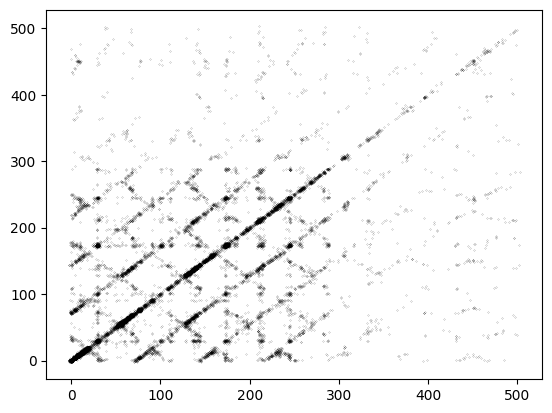

In [39]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_PSYCHOPHYSICSv00_speech_in_noise_in_reverb_v04.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

df0 = df0.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)
df1 = df1.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)
for c in df1.columns:
    if c in df0.columns:
        print(c, np.array_equal(df0[c].values, df1[c].values))
    else:
        print("!", c)

fig, ax = plt.subplots()
x = df1["label_loc_int:labels_pred"].values
y = df0["label_loc_int.pred"].values
ax.plot(x + 1 * np.random.randn(*y.shape), y + 1 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()
